In [1]:
import os
import sys
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

parent_path = os.path.dirname(os.getcwd())
tools_path = os.path.join(parent_path, 'tools')
sys.path.append(parent_path)
sys.path.append(tools_path)

from tools.path import get_env_path, get_prompt_from_file
from tools.agent_GEP import GeneticProgram
from tools.backtest import BacktestEngine
from tools.more_operators import *
from tools.evaluate_and_visualizations import *
from tools.common import update_database

In [2]:
from dotenv import load_dotenv
env = get_env_path('project')
load_dotenv(env)

True

In [3]:
aapl = pd.read_feather(parent_path+'/data/AAPL_with_indicators.feather')
amzn = pd.read_feather(parent_path+'/data/AMZN_with_indicators.feather')
goog = pd.read_feather(parent_path+'/data/GOOGL_with_indicators.feather')
msft = pd.read_feather(parent_path+'/data/MSFT_with_indicators.feather')
tsla = pd.read_feather(parent_path+'/data/TSLA_with_indicators.feather')

In [4]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict, Optional, List

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from pandas import DataFrame


# Agent State在不同node里进行更新并且传输
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # DataFrame就可以在整个pipeline中的多个agent之间共享
    # 允许不同的agent能够对同一份数据进行不同的操作和处理

    # 存储遗传规划产生的最佳信号
    best_signals: List[str]

    # 对下一轮遗传规划的调整
    reflection_result: str

    # 存储当前训练的轮数
    roll: int

In [6]:
# 这个函数用来帮助在每一轮node结束前让进行介入
# 每一个状态会一一拿给人进行检查与修改

def review_and_edit(variable):
    # 输出当前的signal equation供查看
    print(f"Current variable: {variable}")
        
    # 提问是否需要修改signal equation
    edit = input("Do you need to edit the variable? (y/n)")
    if edit.lower() == "y":
        # 提问新的signal equation的值是什么
        revised_variable = input("What do you want to set the new variable to?")
        variable = revised_variable
        
    return variable

In [7]:
def data_node(state):

    global df
    df = aapl
    #df = compute_indicators(df)

    state['roll'] = 0

    return {
        "messages": ["Data loaded from feather file and indicators computed."],
        "best_signals": None,
        "reflection_result": None,
        "roll": state['roll']
    }

def splitter_node(state):
    
    train_size = int(len(df) * 0.8)
    global train_df, test_df
    train_df = df[:train_size]
    test_df = df[train_size:]
    
    return {
        "messages": ['The data has been split into training and testing sets now.'],
        "best_signals": None,
        "reflection_result": None,
        "roll": state['roll']
    }

def GEP_node(state):
    # 这里用来进行遗传规划

    if state['roll'] == 0:
        # 只有第一轮不经调整随便进行规划
        # 1. 用训练集来进行训练
        gp = GeneticProgram(data=train_df, head=10, genes=2)
        # 2. 进行遗传规划,训练出最好的signal信号并且return出来
        pop, log, hof = gp.run(n_pop=200, n_gen=2)

        best_signals = []

        for i in range(3):
            best_signals.append(str(hof[i]))
    
    else:
        # 运行优化后的遗传规划
        reflection_result = state['reflection_result']

        # 需要单独定义下命名空间，从外部访问出来的
        namespace = {'GeneticProgram': GeneticProgram, "train_df": train_df}
        exec(reflection_result, namespace)
        pop, log, hof = namespace['pop'], namespace['log'], namespace['hof']

        best_signals = []

        for i in range(3):
            best_signals.append(str(hof[i]))


    return {
        "messages": ['The GEP process has been made sucessfully.'],
        "best_signals": best_signals, 
        "reflection_result": state['reflection_result'],
        "roll": state['roll']
    }

def backtest_node(state):

    # results用来存储每一个信号的回测结果用于画图
    # databse用于递增存储信号结果
    global results, database
    results = {}
    database = {}

    # 算子与特征
    with open(parent_path + '/prompts/supported_operators.txt', 'r') as file:
        supported_operators = file.read()

    with open(parent_path + '/prompts/supported_factors.txt', 'r') as file:
        supported_factors = file.read()

    for i in range(3):
        llm = ChatOpenAI(model="gpt-4-1106-preview")
        system_prompt = get_prompt_from_file("model_1_backtest_node")

        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )

        prompt = prompt.partial(supported_operators=supported_operators)
        prompt = prompt.partial(supported_factors=supported_factors)
        prompt = prompt.partial(GEP_str=state['best_signals'][i])
        signal_chain = prompt | llm
    
        result = signal_chain.invoke(['help me convert the str to a signal equation'])
    
        signal_equation = str(result.content)
        # 这里需要询问是否要进行修改
        signal_equation = review_and_edit(signal_equation)

        # 训练集结果
        # 全局以便于进行检查
        global bt_train_return, bt_test_return, bt_return

        bt_train = BacktestEngine(data=train_df, signal_str=signal_equation)
        bt_train_return = bt_train.run_backtest()
        train_return_rate, train_max_drawdown, train_sharpe_ratio = get_backtest_ratios(bt_train_return)

        # 测试集结果
        bt_test = BacktestEngine(data=test_df, signal_str=signal_equation)
        bt_test_return = bt_test.run_backtest()
        test_return_rate, test_max_drawdown, test_sharpe_ratio = get_backtest_ratios(bt_test_return)

        bt = BacktestEngine(data=df, signal_str=signal_equation)
        bt_return = bt.run_backtest()

        # results字典存储每一个信号在训练集、测试集、总回测中的收益情况以便于下一步画图
        # 这里创建一个databse，用来递增存储每一个新信号的收益，最大回撤等信息
        results[signal_equation] = {'train_return': bt_train_return, 
                                'test_return': bt_test_return, 
                                'return': bt_return}
        
        database[signal_equation] = {'train_return_rate': train_return_rate, 
                                      'train_max_drawdown': train_max_drawdown, 
                                      'train_sharpe_ratio': train_sharpe_ratio, 
                                      'test_return_rate': test_return_rate, 
                                      'test_max_drawdown': test_max_drawdown, 
                                      'test_sharpe_ratio': test_sharpe_ratio}
        

        # 更新数据库
        base = pd.DataFrame.from_dict(database, orient='index')

        path = parent_path + '/data/quant_chain_with_one_agent_database.feather'
        update_database(base, path)



    return {
        "messages": ['The backtest has been made sucessfully.'],
        "best_signals": state['best_signals'],
        "reflection_result": state['reflection_result'],
        "roll": state['roll']
    }

def eav_node(state):

    # 解开results分别输出
    for signal_equation in results.keys():

        # 总回测结果
        plot_equity_curve_with_split(results[signal_equation]['test_return'], results[signal_equation]['return'])

        # 训练集结果
        plot_train_or_test_return(results[signal_equation]['train_return'], 'backtest_train_return', rf=0.02)
        # 测试集结果
        plot_train_or_test_return(results[signal_equation]['test_return'], 'backtest_test_return', rf=0.02)
    
    return {
        "messages": ["EAV was made"], 
        "best_signals": None,
        "reflection_result": None,
        "roll": state['roll']
    }

In [8]:
def researcher_node(state):
    # researcher这个agent首先要把当前的研究结果给读取出来
    # 然后它要判断当前的结果是否完善，不完善就继续训练，完善了就结束

    state['roll'] += 1

    llm = ChatOpenAI(model="gpt-4-1106-preview")
    
    system_prompt = get_prompt_from_file("model_2_researcher_node")
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    path = parent_path + '/data/quant_chain_with_one_agent_database.feather'
    database = pd.read_feather(path)
    
    prompt = prompt.partial(results=database)
    research_chain = prompt | llm
    
    result = research_chain.invoke(['help me complete the GEP task.'])
    result = result.content

    result = review_and_edit(result)

    state['reflection_result'] = str(result)


    # 到了第二轮进来的时候，要记着把df，train_df，test_df状态保持
    # best_signals清空，以准备下一轮遗传规划
    
    return {
        "messages": ["research decision was made"], 
        "best_signals": None,
        "reflection_result": state['reflection_result'],
        "roll": state['roll']
    }

In [9]:
# 判断是进入call_tool还是continue还是__end__

def router(state):

    if state['roll'] > 5:
        
        return "__end__"

    return "continue"

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node("data_generator", data_node)
workflow.add_node("splitter", splitter_node)
workflow.add_node("GEP", GEP_node)
workflow.add_node("backtest", backtest_node)
workflow.add_node("evaluate_and_visualizations", eav_node)
workflow.add_node("researcher", researcher_node)

workflow.add_edge("data_generator", "splitter")
workflow.add_edge("splitter", "GEP")
workflow.add_edge("GEP", "backtest")
workflow.add_edge("backtest", "evaluate_and_visualizations")
workflow.add_edge("evaluate_and_visualizations", "researcher")

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "GEP" ,"__end__": END},
)

workflow.set_entry_point("data_generator")
graph = workflow.compile()

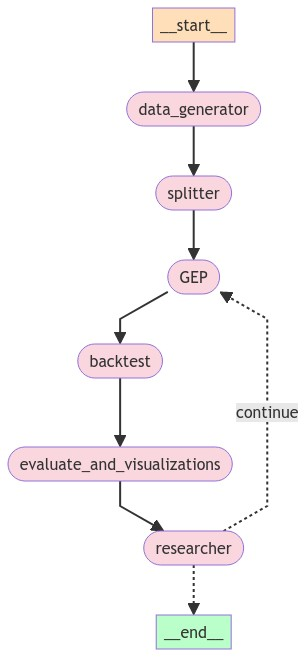

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# 生成数据库
#from tools.common import generate_simple_quant_chain_database
#path = parent_path + '/data/quant_chain_with_one_agent_database.feather'
#generate_simple_quant_chain_database(path)

{'data_generator': {'messages': ['Data loaded from feather file and indicators computed.'], 'best_signals': None, 'reflection_result': None, 'roll': 0}}
----
{'splitter': {'messages': ['The data has been split into training and testing sets now.'], 'best_signals': None, 'reflection_result': None, 'roll': 0}}
----
gen	nevals	avg    	std   	min      	max    
0  	200   	1.20171	2.6159	-0.981898	10.1155
1  	199   	2.6955 	3.54724	-0.981898	10.1155
2  	199   	4.17754	4.03824	-0.981898	10.1155
{'GEP': {'messages': ['The GEP process has been made sucessfully.'], 'best_signals': ['add(\n\tBIAS,\n\tBIAS\n)', 'add(\n\tBIAS,\n\tKAMA(ts_argmax(_high, ts_mean_return(_open, ts_argmin(sub(ts_corr(ATR, _high, EMA), BIAS), BIAS))), DX)\n)', 'add(\n\tMIDPRICE(RSI, 5, RSI),\n\tBIAS\n)'], 'reflection_result': None, 'roll': 0}}
----
Current variable: signals = add(self.df.loc[i, 'BIAS'], self.df.loc[i, 'BIAS'])
Current variable: signals = add(self.df.loc[i, 'BIAS'], KAMA(ts_argmax(self.df.loc[i, 'high'], t

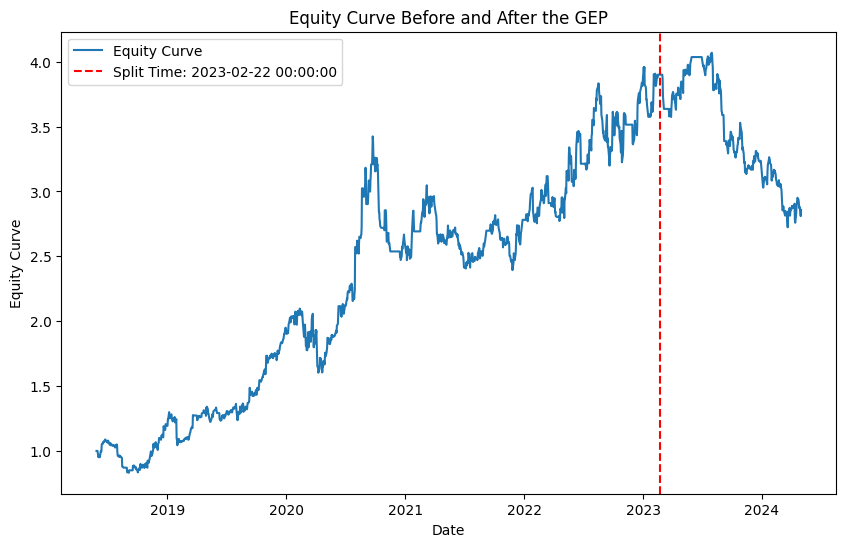

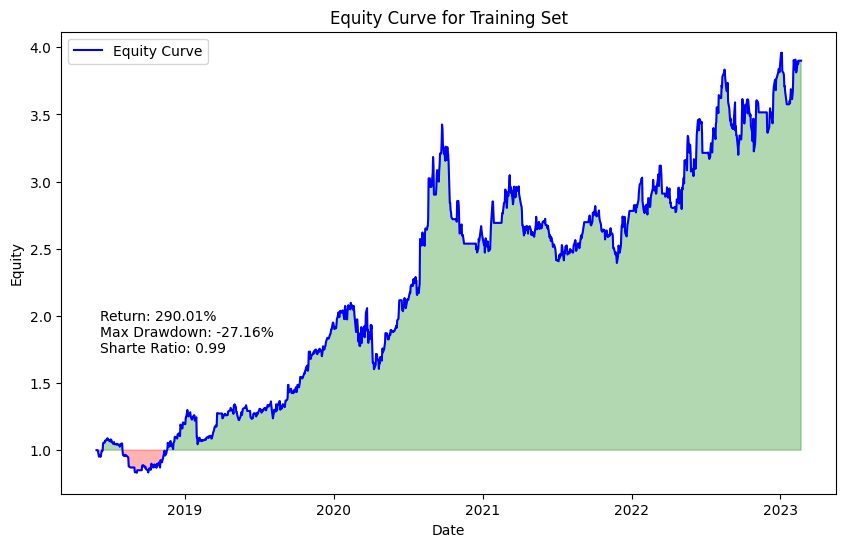

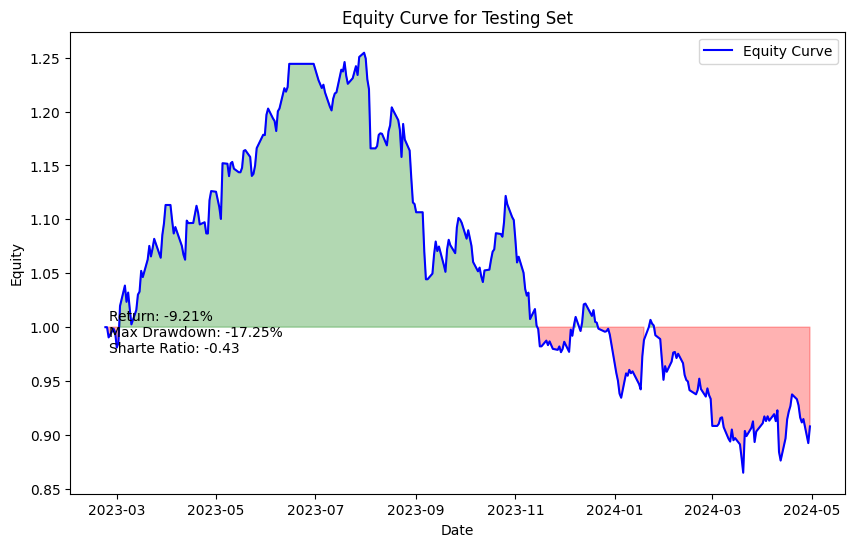

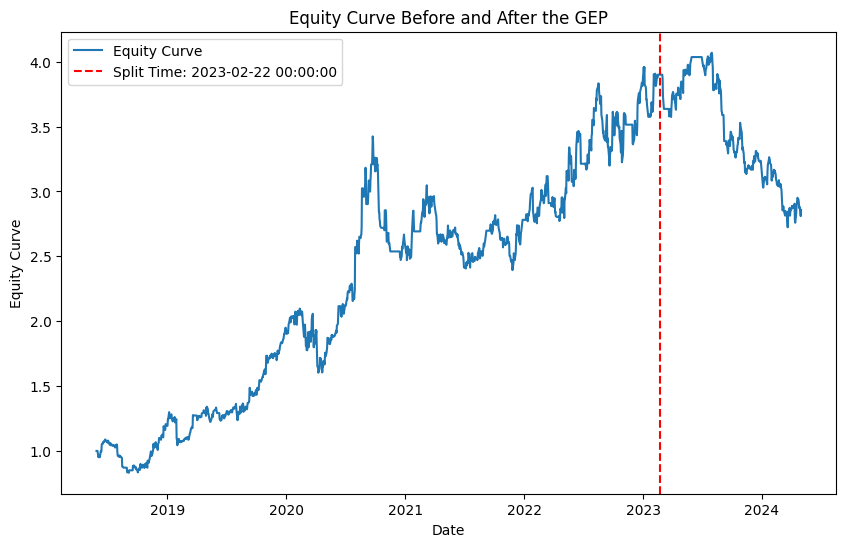

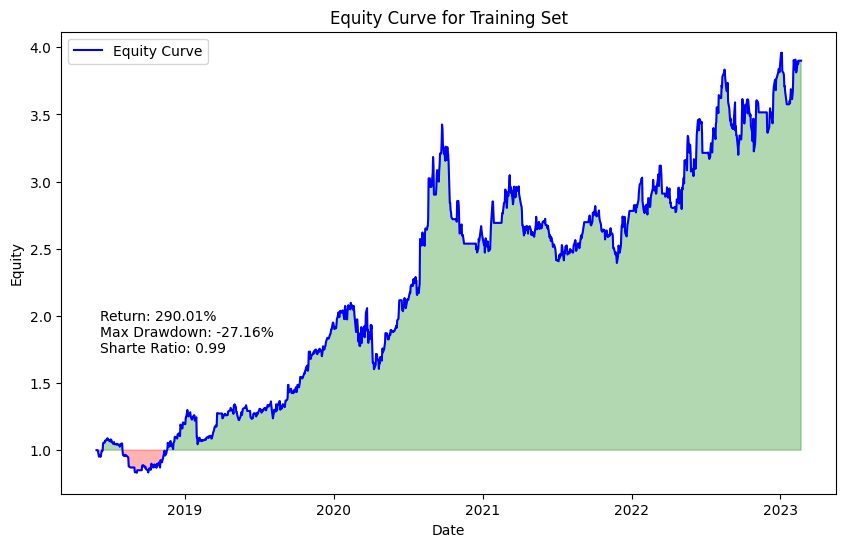

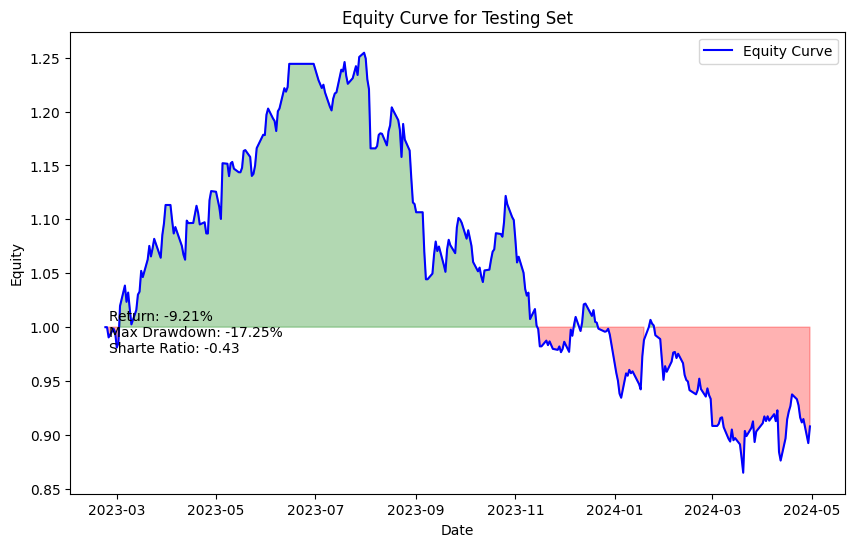

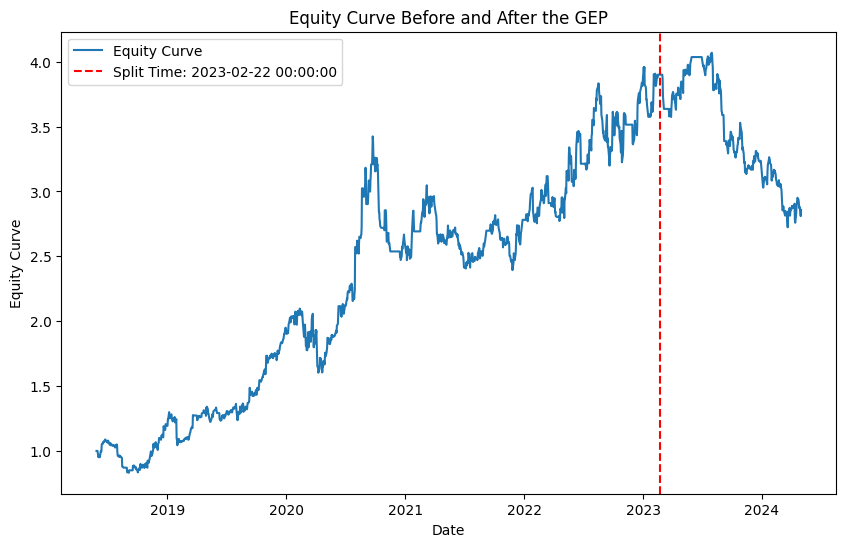

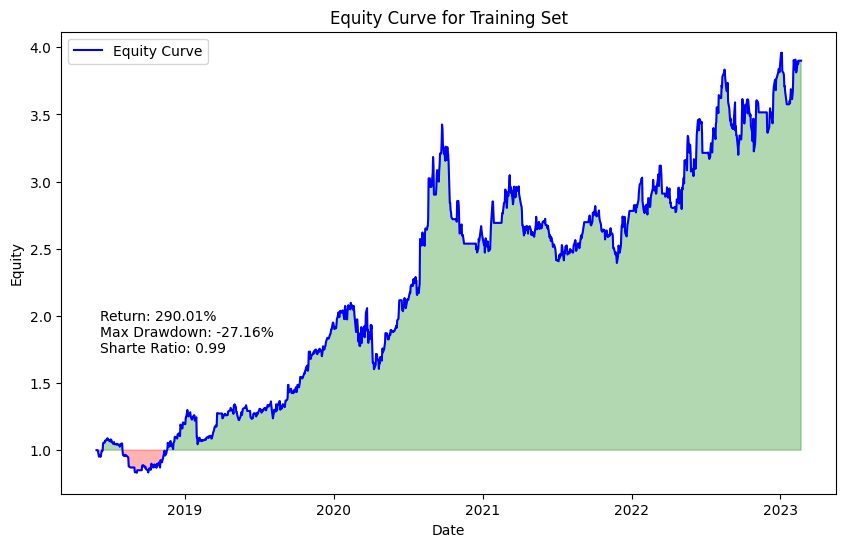

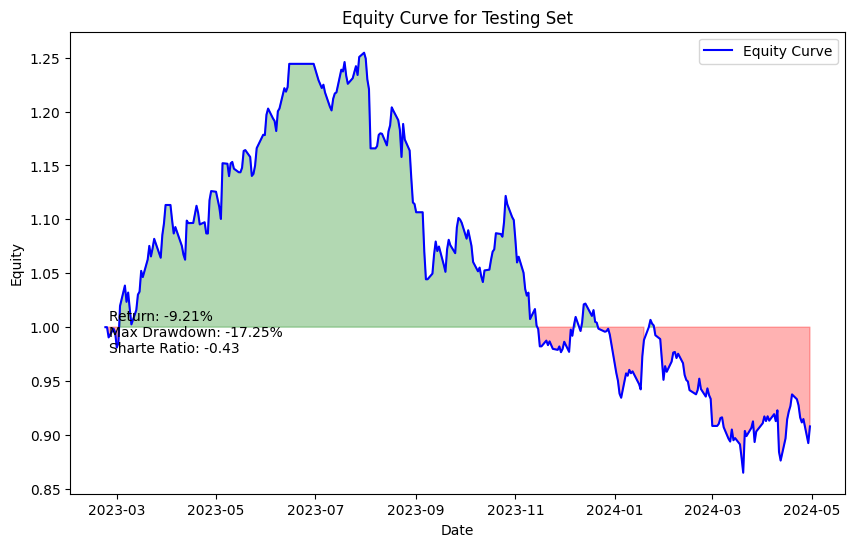

{'evaluate_and_visualizations': {'messages': ['EAV was made'], 'best_signals': None, 'reflection_result': None, 'roll': 0}}
----
Current variable: gp = GeneticProgram(data=train_df, head=15, tournsize=3, mut_invert=0.2, mut_is_transpose=0.2, mut_ris_transpose=0.2, mut_gene_transpose=0.2, cx_1p=0.1, cx_2p=0.1, cx_gene=0.1)
pop, log, hof = gp.run(n_pop=1000, n_gen=10)
{'researcher': {'messages': ['research decision was made'], 'best_signals': None, 'reflection_result': 'gp = GeneticProgram(data=train_df, head=15, tournsize=3, mut_invert=0.2, mut_is_transpose=0.2, mut_ris_transpose=0.2, mut_gene_transpose=0.2, cx_1p=0.1, cx_2p=0.1, cx_gene=0.1)\npop, log, hof = gp.run(n_pop=1000, n_gen=10)', 'roll': 1}}
----
gen	nevals	avg    	std    	min      	max    
0  	1000  	1.07933	2.30602	-0.981898	10.1155
1  	999   	2.29203	3.01551	-0.981898	10.1155
2  	999   	3.5914 	3.66213	-0.989587	10.1155
3  	999   	5.10754	4.04372	-0.981898	10.1155
4  	999   	6.66132	4.10163	-0.989956	12.0401
5  	999   	7.73

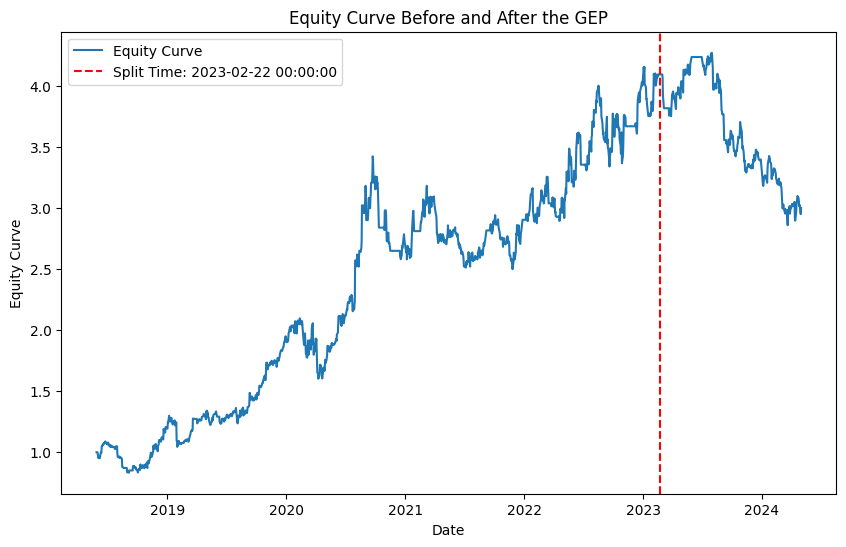

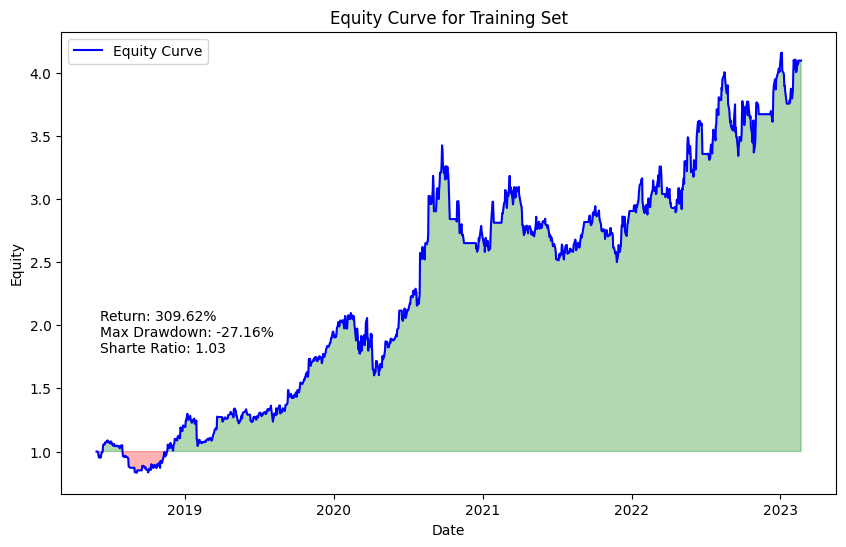

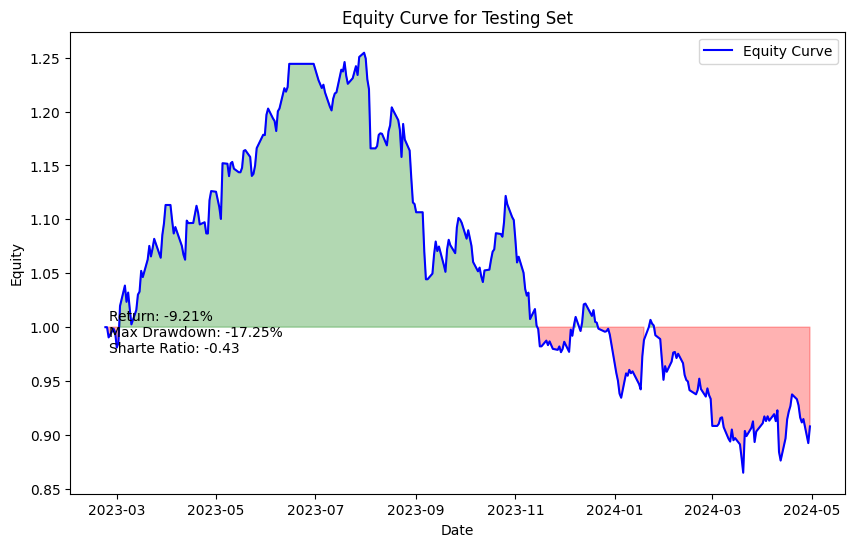

{'evaluate_and_visualizations': {'messages': ['EAV was made'], 'best_signals': None, 'reflection_result': None, 'roll': 1}}
----
Current variable: gp = GeneticProgram(data=train_df, head=15, tournsize=3, mut_invert=0.2, mut_is_transpose=0.2, mut_ris_transpose=0.2, mut_gene_transpose=0.2, cx_1p=0.1, cx_2p=0.1, cx_gene=0.1)
pop, log, hof = gp.run(n_pop=500, n_gen=7)
{'researcher': {'messages': ['research decision was made'], 'best_signals': None, 'reflection_result': 'gp = GeneticProgram(data=train_df, head=15, tournsize=3, mut_invert=0.2, mut_is_transpose=0.2, mut_ris_transpose=0.2, mut_gene_transpose=0.2, cx_1p=0.1, cx_2p=0.1, cx_gene=0.1)\npop, log, hof = gp.run(n_pop=500, n_gen=7)', 'roll': 2}}
----
gen	nevals	avg    	std    	min      	max    
0  	500   	1.05348	2.39499	-0.981898	10.1155
1  	499   	2.30615	3.0874 	-0.981898	10.1155
2  	499   	3.78814	3.79637	-0.876431	10.1155
3  	499   	5.58594	4.1284 	-0.981898	10.1155
4  	499   	7.02639	4.17895	-0.981898	10.1155
5  	499   	7.47661	

NameError: name 'cos' is not defined

In [13]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Lets start !"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

In [14]:
pd.read_feather(parent_path+'/data/quant_chain_with_one_agent_database.feather')

,signal,train_return_rate,train_max_drawdown,train_sharpe_ratio,test_return_rate,test_max_drawdown,test_sharpe_ratio
0,Test,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"signals = add(self.df.loc[i, 'BIAS'], KAMA(KAM...",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
2,"signals = add(self.df.loc[i, 'BIAS'], KAMA(KAM...",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
3,"signals = add(self.df.loc[i, 'BIAS'], MA(ts_mi...",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
4,"signals = add(self.df.loc[i, 'BIAS'], KAMA(KAM...",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
5,"signals = add(self.df.loc[i, 'BIAS'], MA(ts_mi...",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
6,"signals = add(self.df.loc[i, 'BIAS'], 7)",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
7,signals = add(\n ts_mean_return(self.df.loc...,290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
8,signals = add(\n ts_mean_return(self.df.loc...,290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
9,"signals = add(self.df.loc[i, 'BIAS'], ts_stdde...",290.008901,-27.162713,0.990683,-9.205829,-17.247722,-0.434444
